In [1]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from more_itertools import locate
os.chdir('/home/b7009348/WGL_project')

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

# Response Matrix
- R11 ~ R22 
- R12 ~ R21 ~ 0
- So just take mean of R11 or R22 for \<R>

In [4]:
with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    R11 = data['R11'] # e1-e1
del data
R = np.mean(R11)
print(R)

0.7130433641769826


# Selection Response

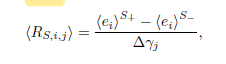

In [6]:
Image.open('des-y1-matched-catalogue/selection_response_eqn.png')

- Need to measure response of estimator to the selection
- Ellipticity distribution is approximately unchanged so might be able to ignore selection response?

# Comparing IM3 and MCAL Tangential Shear 
(count-shear correlation + response correction)

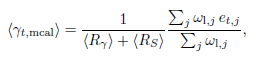

In [23]:
Image.open('des-y1-matched-catalogue/mcal_gammat_eqn.png')

Ry and Rs have no significant variation with $\theta$ so can use constant value

# Shot-noise mcal $\gamma_{t}$

In [6]:
nbins=10
theta_min=2.5
theta_max=250

In [127]:
with fits.open('DES-data/DES_Y1A1_Lenses_z=0.3-0.45.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
del data
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l)

# read in randoms data and create treecorr catalogue
with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    
del data 

cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg')


with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1_m = data['e1']
    e2_m = data['e2']
    
del data

cat_s_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1_m, g2=e2_m)

print('Catalogues created, starting correlation calculation...')

Catalogues created, starting correlation calculation...


In [201]:
mcal_ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
mcal_ng.process(cat_l, cat_s_mcal)

mcal_rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
mcal_rg.process(cat_r, cat_s_mcal)

print('mcal correlation calculation complete.')
    
mcal_xi_l = mcal_ng.xi
mcal_xi_r = mcal_rg.xi

mcal_shot = 1.0/np.mean(R) * (mcal_xi_l - mcal_xi_r)

mcal_theta = np.exp(mcal_ng.meanlogr)

print(mcal_shot)

mcal correlation calculation complete.
[1.22850312e-03 1.08099893e-03 7.90436868e-04 6.62166370e-04
 5.24727494e-04 3.87596783e-04 2.75520094e-04 2.30092429e-04
 1.95619391e-04 1.68357967e-04 1.36384474e-04 1.16712450e-04
 1.17757279e-04 8.40498908e-05 7.41308276e-05 6.92606510e-05
 5.73138861e-05 4.53669400e-05 4.06265932e-05 4.57972790e-05]


# Jackknife mcal $\gamma_{t}$

In [7]:
mcal_shear = np.zeros([nbins])
with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']

del data

cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l)

# read in randoms data and create treecorr catalogue
with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    ra_r = data['RA']
    dec_r = data['dec']

del data 

cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg')


with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1_m = data['e1']
    e2_m = data['e2']
print(np.mean(e1_m), np.mean(e2_m))
del data

cat_s_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1_m, g2=e2_m)

print('Catalogues created, starting correlation calculation...')

mcal_ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
mcal_ng.process(cat_l, cat_s_mcal)

mcal_rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
mcal_rg.process(cat_r, cat_s_mcal)

print('mcal correlation calculation complete.')

mcal_xi_l = mcal_ng.xi
mcal_xi_r = mcal_rg.xi

mcal_shear = 1.0/R * (mcal_xi_l - mcal_xi_r)
print(mcal_shear)

mcal_theta = np.exp(mcal_ng.meanlogr)

0.00042739123215585444 0.00039556766108901674
Catalogues created, starting correlation calculation...
mcal correlation calculation complete.
[6.86773887e-04 4.18748003e-04 2.51111973e-04 1.63911026e-04
 1.19532814e-04 8.17376089e-05 5.69253872e-05 4.77689303e-05
 3.65736193e-05 2.13329518e-05]


In [8]:
mcal_sig=np.sqrt(mcal_ng.varxi)

In [7]:
[1.22850312e-03 1.08099893e-03 7.90436868e-04 6.62166370e-04
 5.24727494e-04 3.87596783e-04 2.75520094e-04 2.30092429e-04
 1.95619391e-04 1.68357967e-04 1.36384474e-04 1.16712450e-04
 1.17757279e-04 8.40498908e-05 7.41308276e-05 6.92606510e-05
 5.73138861e-05 4.53669400e-05 4.06265932e-05 4.57972790e-05]

SyntaxError: invalid syntax (4238717050.py, line 1)

In [9]:
# preallocate output arrays
gammat = np.zeros([nbins])
theta = np.zeros([nbins])

# calculate tangential shear with lenses
ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
ng.process(cat_l, cat_s_mcal)

# calculate tangential shear with randoms
rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
rg.process(cat_r, cat_s_mcal)

xi_l = ng.xi
xi_r = rg.xi

gammat = 1.0/R * (xi_l - xi_r)
theta = np.exp(ng.meanlogr)

In [7]:
print(gammat)

[7.95636808e-04 5.17546260e-04 3.03199967e-04 2.04046861e-04
 1.42479494e-04 9.89397577e-05 6.83941424e-05 5.32118656e-05
 3.90522241e-05 2.57771853e-05]


In [10]:
with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']

del data

cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l)

# read in randoms data and create treecorr catalogue
with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    ra_r = data['RA']
    dec_r = data['dec']
del data 

cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg')

with fits.open('DES-data/y1_im3_shapes_matched.fits') as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
    
del data
 
cat_s_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, w=w)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w)
    
# do correlations with lenese, NKCorrelation is used to apply multiplicative correction
im3_ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
im3_ng.process(cat_l, cat_s_im3)
nk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
nk.process(cat_l, cat_k)
    
# do correlations with randoms
im3_rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
im3_rg.process(cat_r, cat_s_im3)
rk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
rk.process(cat_r, cat_k)
    
# correlation functions and corrections for lenses and randoms
im3_xi_l = im3_ng.xi
sens_l = nk.xi
im3_xi_r = im3_rg.xi
sens_r = rk.xi
    
# store data in preallocated arrays
im3_Gammat = im3_xi_l/sens_l - im3_xi_r/sens_r
im3_theta = np.exp(im3_ng.meanlogr)
im3_sig = np.sqrt(im3_ng.varxi)

del e1, e2, sens, w

print(im3_Gammat)

[7.35735483e-04 4.73248206e-04 2.78896960e-04 1.82505716e-04
 1.38235876e-04 8.87096406e-05 6.25192983e-05 5.31940519e-05
 4.05601297e-05 2.37784065e-05]


In [ ]:
[1.32068846e-03 1.23358195e-03 8.81803604e-04 7.01044519e-04
 5.78059423e-04 3.53420240e-04 3.51769537e-04 2.45856565e-04
 2.37698821e-04 1.95477594e-04 1.49401379e-04 1.12284954e-04
 1.33694904e-04 8.77625216e-05 7.62512625e-05 7.97066717e-05
 6.72352199e-05 5.52777280e-05 4.97616028e-05 4.76798067e-05]

In [11]:
selection_bias = [1.86604277e-05, 1.15365157e-05, 7.37264433e-06, 4.81941664e-06,
 3.24334323e-06, 2.43693109e-06, 1.56456569e-06, 1.26168937e-06,
 9.74208093e-07, 6.85927059e-07]

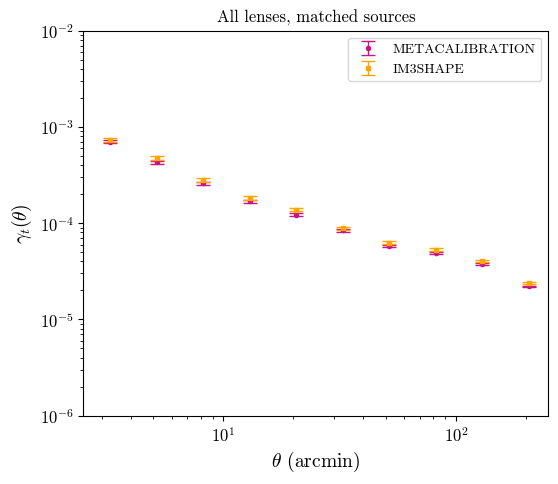

In [14]:
plt.figure(figsize=[6,5])
plt.errorbar(mcal_theta, mcal_shear+selection_bias, yerr=mcal_sig, linewidth=0, marker='o', elinewidth=1, capsize=5, color='mediumvioletred', markersize=3)
plt.errorbar(im3_theta, im3_Gammat, yerr=im3_sig, linewidth=0, marker='s', elinewidth=1, capsize=5, color='orange', markersize=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.ylabel(r'$\gamma_{t}(\theta)$', fontsize=14)
plt.title(r'All lenses, matched sources')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['METACALIBRATION', 'IM3SHAPE'])
plt.savefig('des-y1-matched-catalogue/matched-sources_all-lenses.png', dpi=300)

In [27]:
print((im3_Gammat-mcal_shear) / 0.03)

[-8.05205112e-04  2.01673469e-04 -1.77584948e-05  4.95309448e-05
  8.90100083e-05 -1.86414254e-06 -3.31192649e-05 -1.24398412e-05
  2.00530034e-05 -3.75817237e-05]


In [ ]:
print(mcal_Gammat)
print(im3_Gammat)

In [ ]:
ratio = im3_Gammat/mcal_Gammat
perc = (ratio-1.0)*100
print(perc)

In [9]:
mcal_Gammat - im3_Gammat

array([-5.83268041e-05, -5.78668110e-05, -1.05974685e-04, -1.29677766e-05,
       -4.98993470e-05,  4.11074606e-06, -3.09296175e-05, -3.28305375e-05,
       -1.56082436e-05, -2.16373865e-05, -5.48746627e-06, -5.05902545e-06,
       -5.40312926e-06, -5.73341290e-06, -3.80888373e-06, -4.69134936e-06,
       -5.76829392e-06, -5.81383778e-06, -4.82213056e-06, -3.14983124e-07])

# Recreating Prat et al. 2018 MCAL plots

In [27]:
zmins = [0.2,0.43,0.63,0.9]
zmaxs = [0.43,0.63,0.9,1.3]

for i in range(len(zmins)):
    des_functions.cut_redshift(shapefile='y1_mcal_flags=0.fits', zfile='y1a1-gold-mof-badregion_BPZ.fits',
                              zmin=zmins[i], zmax=zmaxs[i], method='mcal')

Opening files...
Locating sources in range 0.2 - 0.43...
Sources in range found, slicing data...
Matching redshifts to catalogue...
Slicing catalogue data...
Data sliced, writing to new file...
Runtime: 1483.61
Opening files...
Locating sources in range 0.43 - 0.63...
Sources in range found, slicing data...
Matching redshifts to catalogue...
Slicing catalogue data...
Data sliced, writing to new file...
Runtime: 1044.52
Opening files...
Locating sources in range 0.63 - 0.9...
Sources in range found, slicing data...
Matching redshifts to catalogue...
Slicing catalogue data...
Data sliced, writing to new file...
Runtime: 931.796
Opening files...
Locating sources in range 0.9 - 1.3...
Sources in range found, slicing data...
Matching redshifts to catalogue...
Slicing catalogue data...
Data sliced, writing to new file...
Runtime: 291.655


In [47]:
data_dir = 'DES-data/'

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+'DES_Y1A1_Lenses_z=0.3-0.45.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=20)

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', patch_centers=cat_l.patch_centers)

# delte data to free memory
del indexes, data

# define bin and scale params
nbins=20
theta_min=2.5
theta_max=250

nlens = float(len(ra_l)) # number of lenses
nrand = float(len(ra_r)) # number of randoms

# list of source files to compute cross-correlation for 
source_files = ['y1_mcal_z=0.9-1.3.fits', 'y1_mcal_z=0.63-0.9.fits', 'y1_mcal_z=0.43-0.63.fits', 'y1_mcal_z=0.2-0.43.fits']
Rs = [0.014, 0.0098, 0.014, 0.0072]

# empty arrays to store correlation function data 
Gammat = np.zeros([nbins,len(source_files)])
sig = np.zeros([nbins,len(source_files)])
theta = np.zeros([nbins,len(source_files)])
Boost = np.zeros_like(Gammat)
theta_b = np.zeros_like(Gammat)

# loops over source files and computes cross-correltaion for different source redshift samples
for i in range(len(source_files)):
    with fits.open(data_dir+source_files[i]) as hdu:
        data = hdu[1].data
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1']
        e2 = data['e2']
        R = np.mean(data['R11'])
    del data
 
    cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, patch_centers=cat_l.patch_centers)
    
    # do correlations with lenese, NKCorrelation is used to apply multiplicative correction
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    ng.process(cat_l, cat_s)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    rg.process(cat_r, cat_s)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    xi_r = rg.xi
    
    # store data in preallocated arrays
    Gammat[:,i] = 1.0/(R+Rs[i]) * (xi_l - xi_r)
    theta[:,i] = np.exp(ng.meanlogr)
    
    # all errors
    l_err = np.sqrt(ng.varxi) # error on lens-shear cross-corr
    r_err = np.sqrt(rg.varxi) # error on random-shear cross-corr
    
    # next do errors for subtraction of randoms to get error on gamma_t
    sig[:,i] = np.sqrt(l_err**2 + r_err**2)
    
    perc = Rs[i]/R * 100.0
    print(perc)

2.5406275758772914
1.5924190864449301
2.269215786803211
0.9666339423765827


In [13]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'

plt.figure(figsize=[6,5])
plt.errorbar(theta[:,3], Gammat[:,3], yerr=sig[:,3], lw=0, marker='o', color='navy', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,2], Gammat[:,2], yerr=sig[:,2], lw=0, marker='o', color='darkmagenta', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,1], Gammat[:,1], yerr=sig[:,1], lw=0, marker='o', color='mediumvioletred', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,0], Gammat[:,0], yerr=sig[:,0], lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.ylabel(r'$\gamma_{t}(\theta)$', fontsize=14)
plt.legend(title='Source redshifts', labels=[r'$0.20<z_{s}<0.43$', r'$0.43<z_{s}<0.63$', r'$0.63<z_{s}<0.90$', r'$0.90<z_{s}<1.30$'], fontsize=11)
plt.title(r'$0.30<z_{l}<0.45$', fontsize=14)
plt.savefig('des-y1-matched-catalogue/mcal_zl=0.3-0.45.png', dpi=300)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 432x360 with 0 Axes>

In [5]:
data_dir = 'DES-data/'

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+'DES_Y1A1_Lenses_z=0.3-0.45.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, patch_centers=data_dir+'jackknife_patch_centers')

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.15 < x < 0.3)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', patch_centers=data_dir+'jackknife_patch_centers')

# delte data to free memory
del indexes, data

# define bin and scale params
nbins=20
theta_min=2.5
theta_max=250

nlens = float(len(ra_l)) # number of lenses
nrand = float(len(ra_r)) # number of randoms

# list of source files to compute cross-correlation for 
source_files = ['y1_mcal_flags=0.fits', 'y1_mcal_shapes_matched.fits']

# empty arrays to store correlation function data 
Gammat = np.zeros([nbins,len(source_files)])
sig = np.zeros([nbins,len(source_files)])
theta = np.zeros([nbins,len(source_files)])
Boost = np.zeros_like(Gammat)
theta_b = np.zeros_like(Gammat)

# loops over source files and computes cross-correltaion for different source redshift samples
for i in range(len(source_files)):
    with fits.open(data_dir+source_files[i]) as hdu:
        data = hdu[1].data
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1']
        e2 = data['e2']
        R = np.mean(data['R11'])
    del data
 
    cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, patch_centers=data_dir+'jackknife_patch_centers')
    
    # do correlations with lenese, NKCorrelation is used to apply multiplicative correction
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    ng.process(cat_l, cat_s)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    rg.process(cat_r, cat_s)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    xi_r = rg.xi
    
    # store data in preallocated arrays
    Gammat[:,i] = 1.0/R * (xi_l - xi_r)
    theta[:,i] = np.exp(ng.meanlogr)
    
    # all errors
    l_err = np.sqrt(ng.varxi) # error on lens-shear cross-corr
    r_err = np.sqrt(rg.varxi) # error on random-shear cross-corr
    
    # next do errors for subtraction of randoms to get error on gamma_t
    sig[:,i] = np.sqrt(l_err**2 + r_err**2)
    

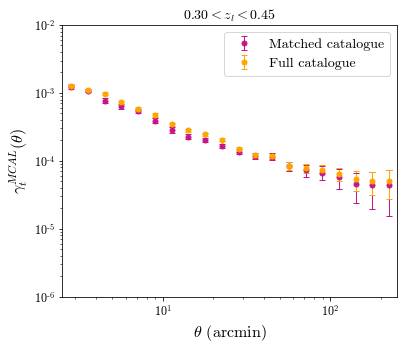

In [10]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'

plt.figure(figsize=[6,5])
plt.errorbar(theta[:,1], Gammat[:,1], yerr=sig[:,1], lw=0, marker='o', color='mediumvioletred', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,0], Gammat[:,0], yerr=sig[:,0], lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=16)
plt.ylabel(r'$\gamma_{t}^{MCAL}(\theta)$', fontsize=16)
plt.legend(['Matched catalogue', 'Full catalogue'], fontsize=14)
plt.title(r'$0.30<z_{l}<0.45$', fontsize=14)
plt.savefig('des-y1-matched-catalogue/mcal_comparison_zl=0.3-0.45.png', dpi=300)